In [1]:
import sys
sys.path.insert(0, '../../../network')

In [2]:
import logging
import argparse
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from network import Population, RateNetwork
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule
from sequences import GaussianSequence

logging.basicConfig(level=logging.INFO)

In [3]:
phi = ErrorFunction(mu=0.22, sigma=0.1).phi
ctx = Population(N=1000, tau=1e-2, phi=phi, name='ctx')
bg = Population(N=1000, tau=1e-2, phi=phi, name='bg')
plasticity = ThresholdPlasticityRule(x_f=0.5, q_f=0.8) 

S, P = 1, 3
sequences_ctx = [GaussianSequence(P,ctx.size, seed=5) for i in range(S)]
patterns_ctx = np.stack([s.inputs for s in sequences_ctx])
sequences_bg = [GaussianSequence(P,ctx.size, seed=27) for i in range(S)]
patterns_bg = np.stack([s.inputs for s in sequences_bg])

J_cc = SparseConnectivity(source=ctx, target=ctx, p=0.05)
synapse_cc = LinearSynapse(J_cc.K, A=5)
J_cc.store_attractors(patterns_ctx[0], patterns_ctx[0], synapse_cc.h_EE, 
                      plasticity.f, plasticity.g)
J_bb = SparseConnectivity(source=bg, target=bg, p=0.05)
synapse_bb = LinearSynapse(J_bb.K, A=5)
J_bb.store_attractors(patterns_bg[0], patterns_bg[0], synapse_bb.h_EE, 
                      plasticity.f, plasticity.g)
J_cb  = SparseConnectivity(source=bg, target=ctx, p=0.05)
synapse_cb = LinearSynapse(J_cb.K, A=1)
J_cb.store_attractors(patterns_bg[0], patterns_ctx[0], synapse_cb.h_EE, 
                      plasticity.f, plasticity.g)

J_bc = SparseConnectivity(source=ctx, target=bg, p=0.05)
synapse_bc = LinearSynapse(J_cc.K, A=0)
J_bc.store_sequences(patterns_ctx, patterns_bg, synapse_bc.h_EE, plasticity.f, plasticity.g)
J_bc.update_sequences(patterns_ctx[0][0], patterns_bg[0][1],
                   1, lamb=1,f=plasticity.f, g=plasticity.g)
J_bc.update_sequences(patterns_ctx[0][1], patterns_bg[0][2],
                   1, lamb=1,f=plasticity.f, g=plasticity.g)
J_bc.update_sequences(patterns_ctx[0][2], patterns_bg[0][0],
                   1, lamb=1,f=plasticity.f, g=plasticity.g)
net_ctx = RateNetwork(ctx, c_EE=J_cc, c_IE=J_bc, formulation=4)
net_bg = RateNetwork(bg, c_II=J_bb, c_EI=J_cb, formulation=4)

INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Storing attractors
100%|██████████████████████████████████████████| 1000/1000 [00:00<00:00, 20044.56it/s]
INFO:connectivity:Building connections from bg to bg
INFO:connectivity:Storing attractors
100%|██████████████████████████████████████████| 1000/1000 [00:00<00:00, 21741.50it/s]
INFO:connectivity:Building connections from bg to ctx
INFO:connectivity:Storing attractors
100%|██████████████████████████████████████████| 1000/1000 [00:00<00:00, 21568.98it/s]
INFO:connectivity:Building connections from ctx to bg
INFO:connectivity:Storing sequences
100%|███████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.69it/s]
INFO:connectivity:Applying synaptic transfer function
INFO:connectivity:Building sparse matrix


In [4]:
init_input_ctx = phi(patterns_ctx[0][0])
init_input_bg = phi(patterns_bg[0][0])
# init_input_ctx = np.random.normal(net_ctx.size)
# init_input_bg = np.random.normal(net_bg.size)
T=2
net_ctx.simulate_euler2(net_bg, T, init_input_ctx, init_input_bg)

INFO:network:Integrating network dynamics
100%|████████████████████████████████████████████| 1999/1999 [00:03<00:00, 593.51it/s]


In [5]:
# overlaps = sequences_ctx[0].overlaps(net_ctx, ctx, phi=phi)
overlaps_ctx = sequences_ctx[0].overlaps(net_ctx, ctx, phi=phi)
overlaps_bg = sequences_bg[0].overlaps(net_bg, bg, phi=phi)

INFO:sequences:Computing overlaps
100%|█████████████████████████████████████████████████| 3/3 [00:00<00:00, 1501.36it/s]
INFO:sequences:Computing overlaps
100%|█████████████████████████████████████████████████| 3/3 [00:00<00:00, 1034.18it/s]


In [6]:
sns.set_style('dark') 
colors = sns.color_palette('deep')


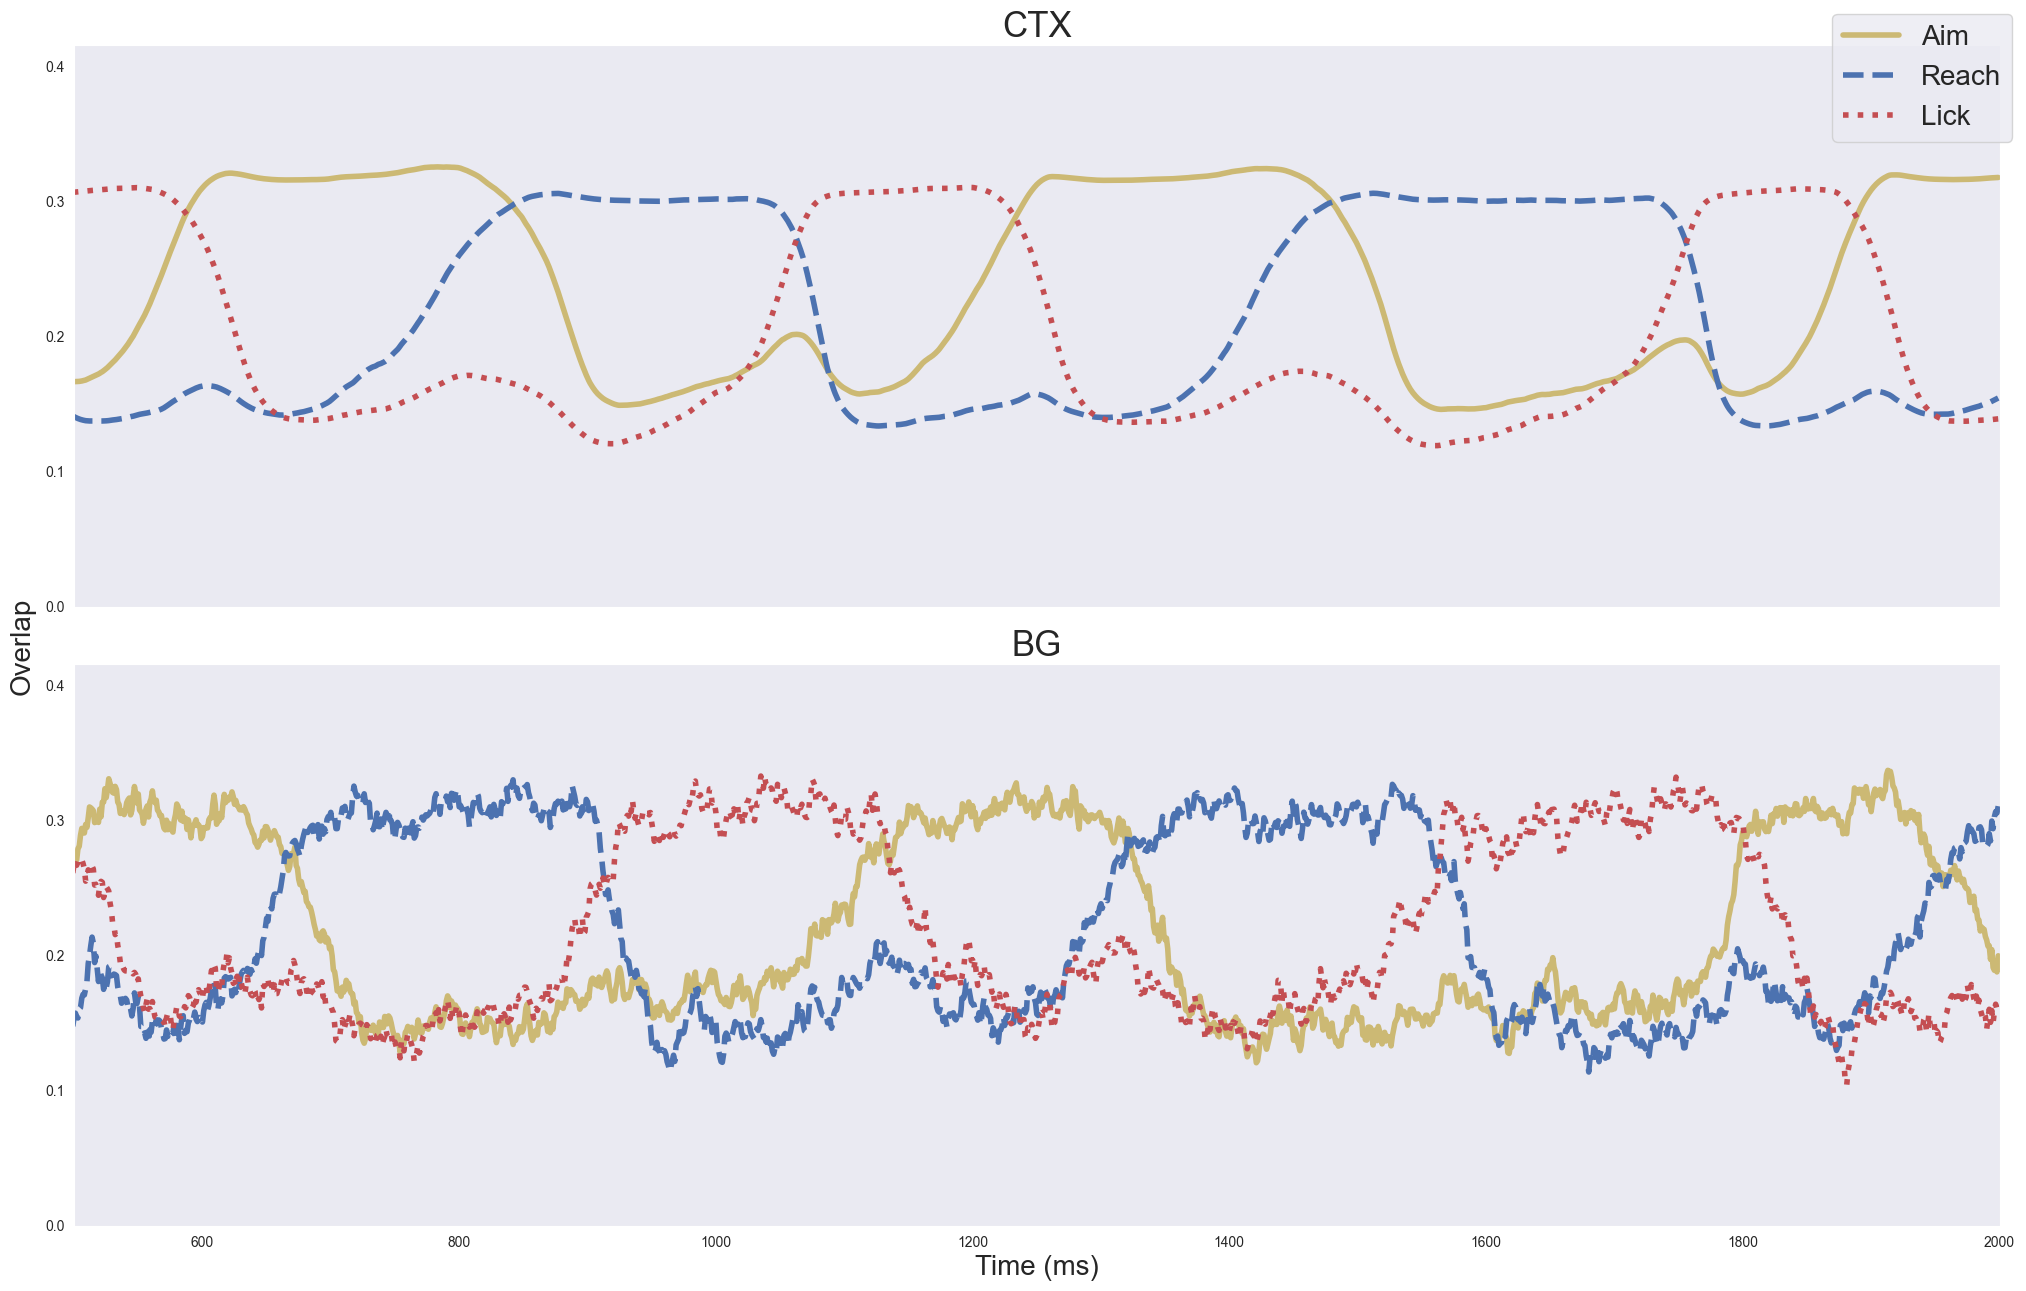

In [8]:
fig, axes = plt.subplots(2,1, sharex=True, sharey=True, tight_layout=True, figsize=(20,13))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=4, color=colors[8])
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=4, color=colors[0])
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=4, color=colors[3])
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=25)
axes[1].plot(overlaps_bg[0], linestyle='solid', linewidth=4, color=colors[8])
axes[1].plot(overlaps_bg[1], linestyle='dashed', linewidth=4, color=colors[0])
axes[1].plot(overlaps_bg[2], linestyle='dotted', linewidth=4, color=colors[3])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("BG", fontsize=25)
axes[1].set_xlabel('Time (ms)', fontsize=20)
fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(500, 2000))
plt.figlegend(labels=['Aim', 'Reach', 'Lick'], fontsize=20)
plt.show()


In [10]:
np.savez('./output/raster.npz', overlaps_ctx=overlaps_ctx, overlaps_bg=overlaps_bg, state1=net_ctx.exc.state, state2=net_bg.exc.state)